## Machine Learning Course (part 3)

- This document summarizes machine learning introduction from [Machine learning course from Kaggle](https://www.kaggle.com/learn/machine-learning).
- You can download data required for the following exercises through [Kaggle API](https://github.com/Kaggle/kaggle-api)

## XGBoost

In [18]:
# Download dataset
!kaggle competitions download -c house-prices-advanced-regression-techniques --path ./data_files --file train.csv

train.csv: Skipping, found more recently modified local copy (use --force to force download)


### Step 1 : Basic problem set-up

In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

my_imputer = SimpleImputer()

data = pd.read_csv('./data_files/train.csv')
data.dropna(axis='rows', subset=['SalePrice'], inplace=True)

y = data.SalePrice
x = data.drop(['SalePrice'], axis='columns').select_dtypes(exclude=['object'])

train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.25)

my_imputer = SimpleImputer()
train_x = my_imputer.fit_transform(train_x)
test_x = my_imputer.transform(test_x)

### Step 2 : Build and fit a model

In [7]:
from xgboost import XGBRegressor

my_model = XGBRegressor()
my_model.fit(train_x, train_y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

### Step 3 : Evaluate a model and make predictions

In [11]:
predictions = my_model.predict(test_x)

from sklearn.metrics import mean_absolute_error
print("MAE : {}".format(str(mean_absolute_error(predictions, test_y))))

MAE : 17202.150406678084


### Step 4 : Model tuning
#### n_estimators and early_stopping_rounds
**n_estimators** specifies how many times to go through the modeling cycle. Too low n_estimator value causes underfitting, which is inaccurate predictions on both training data and new data. Too large n_estimator value causes overfitting, which is accurate predictions on training data, but inaccurate predictions on new data. Typical values range from 100-1000, though this depends a lot on the **learning rate**.

The argument **early_stopping_rounds** offers a way to automatically find the ideal value. Early stopping causes the model to stop iterating when the validation score stops improving, even if we aren't at the hard stop for n_estimators. It's smart to set a high value for **n_estimators** and then use **early_stopping_rounds** to find the optimal time to stop iterating.

Since random chance somtimes causes a single round where validation scores don't imporve, you need to specify a number for how many rounds of straight deterioration to allow before stopping. **early_stopping_rounds = 5** is a reasonable value. Thus we stop after 5 straight rounds of deteriorating validation scores.

In [19]:
my_model = XGBRegressor(n_estimators=1000)
my_model.fit(train_x, train_y, early_stopping_rounds=5, eval_set=[(test_x, test_y)], verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [14]:
predictions = my_model.predict(test_x)
print("MAE : {}".format(str(mean_absolute_error(predictions, test_y))))

MAE : 17187.834696061644


#### learning_rate

In general, a small **learning_rate** (and large number of estimators) will yield more accurate XGBoost models, though it will also take the model longer to train since it does more iterations thorugh the cycle. 

In [20]:
my_model = XGBRegressor(n_estimators=1000, learning_rate=0.05)
my_model.fit(train_x, train_y, early_stopping_rounds=5, eval_set=[(test_x, test_y)], verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [17]:
predictions = my_model.predict(test_x)
print("MAE : {}".format(str(mean_absolute_error(predictions, test_y))))

MAE : 16992.703232020547


---- 

## Partial dependence plots

In [1]:
# download sample data
!kaggle datasets download --path ./data_files --unzip dansbecker/melbourne-housing-snapshot

100%|████████████████████████████████████████| 451k/451k [00:00<00:00, 1.23MB/s]



### Step 1 : Basic problem set-up

In [8]:
data = pd.read_csv('./data_files/melb_data.csv')
y = data.Price
x = data[['Distance', 'Landsize', 'BuildingArea']]

my_imputer = SimpleImputer()
imputed_x = my_imputer.fit_transform(x)

### Step 2 : Make the partial dependence plot

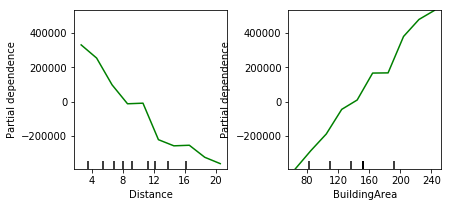

In [18]:
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt

# scikit-learn originally implemented partial dependence plots  only for Gradient Boosting models
# this was due to an implementation detail, and a future release will support all model types.
my_model = GradientBoostingRegressor()
my_model.fit(imputed_x, y)

my_plots = plot_partial_dependence(my_model, features=[0,2], X=imputed_x, 
                                   feature_names = ['Distance', 'Landsize', 'BuildingArea'], grid_resolution=10)

----

## Pipelines

### Step 1 : Basic problem set-up

In [20]:
data = pd.read_csv('./data_files/melb_data.csv')
y = data.Price
x = data[['Rooms', 'Distance', 'Landsize', 'BuildingArea', 'YearBuilt']]

train_x, test_x, train_y, test_y = train_test_split(x, y)

### Step 2 : Make a pipeline

In [22]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline

my_pipeline = make_pipeline(SimpleImputer(), RandomForestRegressor())

### Step 3 : Fit and predict using the pipeline

In [23]:
my_pipeline.fit(train_x, train_y)
predictions = RandomForestRegressor()

/Users/inbumsung/workspace/venv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


### Step 4 : Get the cross-validation scores

In [28]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(my_pipeline, x, y, scoring='neg_mean_absolute_error')
print(scores)
print('Mean Aboslute Error {:2f}'.format(-1 * scores.mean()))

/Users/inbumsung/workspace/venv/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


[-312835.38995804 -295610.83037668 -299691.80582508]
Mean Aboslute Error 302712.675387


----

## Preventing data leakage

In [39]:
# download dataset
!kaggle datasets download --path ./data_files --unzip like1008/aer-credit-card-datacsv

  0%|                                               | 0.00/23.6k [00:00<?, ?B/s]
100%|███████████████████████████████████████| 23.6k/23.6k [00:00<00:00, 408kB/s]


In [47]:
from sklearn.ensemble import RandomForestClassifier

data = pd.read_csv('./data_files/AER_credit_card_data.csv', true_values = ['yes'], false_values = ['no'])

y = data.card
x = data.drop(['card'], axis='columns')

my_pipeline = make_pipeline(RandomForestClassifier())
cv_scores = cross_val_score(my_pipeline, x, y, scoring='accuracy')
print('Cross-val accuracy : {:f}'.format(cv_scores.mean()))

Cross-val accuracy : 0.980286


/Users/inbumsung/workspace/venv/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/inbumsung/workspace/venv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/inbumsung/workspace/venv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/inbumsung/workspace/venv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 

It's very rare to find models that are accurate 98% of the time. It happens, but it's rare enough that we should inspect the data more closely to see if it is target leakage. 

Here is a summary of the data, which you can also find under the data tab:

- card: Dummy variable, 1 if application for credit card accepted, 0 if not
- reports: Number of major derogatory reports
- age: Age n years plus twelfths of a year
- income: Yearly income (divided by 10,000)
- share: Ratio of monthly credit card expenditure to yearly income
- expenditure: Average monthly credit card expenditure
- owner: 1 if owns their home, 0 if rent
- selfempl: 1 if self employed, 0 if not.
- dependents: 1 + number of dependents
- months: Months living at current address
- majorcards: Number of major credit cards held
- active: Number of active credit accounts

A few variables look suspicious. For example, does expenditure mean expenditure on this card or on cards used before appying?

At this point, basic data comparisons can be very helpful:

In [64]:
expenditure_cardholders = data.loc[data.card].expenditure
expenditure_noncardholders = data.loc[~data.card].expenditure

print('Fraction of those who received a card with no expenditures : {:.2f}'
     .format((expenditure_cardholders == 0).mean()))
print('Fraction of those who was not received a card with no expenditures : {:.2f}'
     .format((expenditure_noncardholders == 0).mean()))

Fraction of those who received a card with no expenditures : 0.02
Fraction of those who was not received a card with no expenditures : 1.00


> Everyone with `card == False` has no expenditures, while only 2% of those with `card == True` had no expenditures. It's not surprising that our model appeard to have a high accuracy. But this seems a data leak, where expenditures probably means **expenditures on the card they applied for**.

Since **share** is partially determined by **expenditure**, it should be excluded too. The variables **active**, **majorcards** are a little less clear, but from the description, they sound concerning. In most situations, it's better to be safe than sorry if you can't track down the people who created the data to find out more.

In [66]:
potential_leaks = ['expenditure', 'share', 'active', 'majorcards']
x2 = x.drop(potential_leaks, axis='columns')
cv_scores = cross_val_score(my_pipeline, x2, y, scoring='accuracy')

print('Cross-val accuracy : {:f}'.format(cv_scores.mean()))

Cross-val accuracy : 0.804411


/Users/inbumsung/workspace/venv/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/inbumsung/workspace/venv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/inbumsung/workspace/venv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/inbumsung/workspace/venv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 